In [37]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import  matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 15)


import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../plankton'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Welcome!

This is the empty notebook for plankton's data handling tutorial, which can be found at [https://link-url-here.org](https://link-url-here.org)

To make it easier, we already implemented the data loading routine that fetches Qian&al's Hippocampal ISS data set and opens it into 'qian_et_al':

### Loading ISS data

In [2]:
# #data loading

# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import os 

# data_folder='../test/qian-et-al/data/leftCA1/'

# xiaoyan_et_al = pd.read_csv(os.path.join(data_folder,'spots_w_segmentation_leftCA1_4-3.csv'))

# dapi_image = plt.imread(os.path.join(data_folder,'./CA1DapiBoundaries_4-3_left.tif'))
# dapi_image = 1-(dapi_image/dapi_image.max())

# #display pandas data set
# xiaoyan_et_al

### Loading spot data 

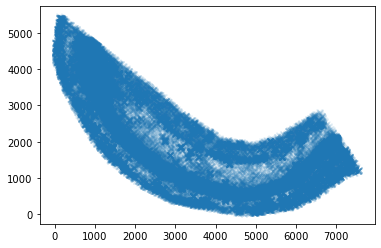

In [13]:
import requests
import io

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ISS_url = 'https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/iss/spots.csv?raw=true'

response = requests.get(ISS_url)
response.raise_for_status()
spot_data = pd.read_csv(io.BytesIO(response.content),)
# plt.imshow(cell_map,cmap='nipy_spectral')
plt.scatter(spot_data.x,spot_data.y,marker='x',alpha=0.1)

# Pixel maps:

### Loading dapi background
A simple DAPI-intensity image can be used as a plotting background.

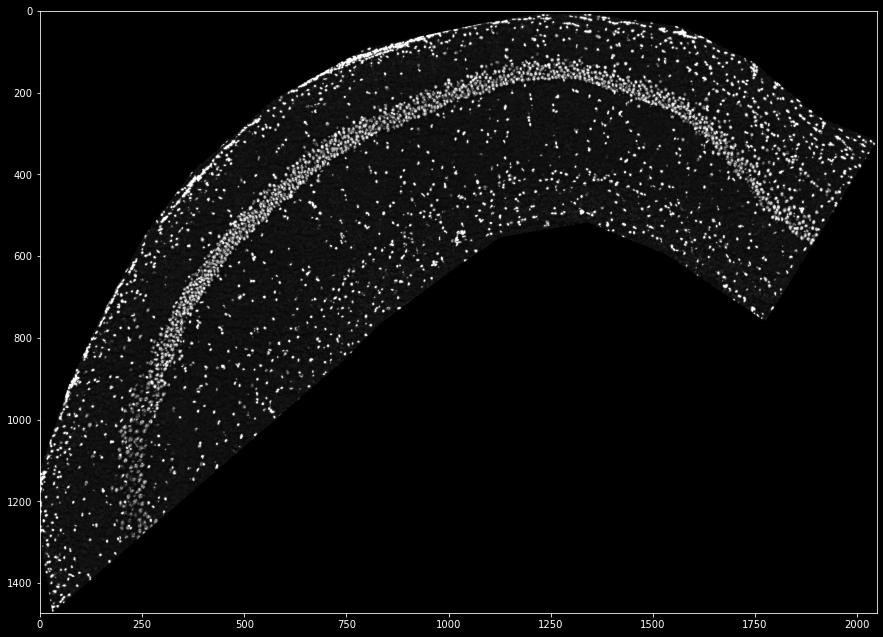

In [123]:
# dapi_data = plt.imread(os.path.join(data_folder,'pancreas_bg.jpg')).mean(-1).T
dapi_data = np.load(os.path.join('../test/qian-et-al/data/DAPI.npy')).astype(float)

# dapi_data/=dapi_data.max()
# dapi_data=1-dapi_data

# dapi_data=np.pad(dapi_data,((0,0),(0,0),),'constant',constant_values=dapi_data.max())

plt.imshow(dapi_data,cmap='Greys')

### Loading segmented cell map

The experiment also generated a cell map of segmented cell areas, where each cell is encoded by a different integer on the pixel map. Background is encoded as "0".

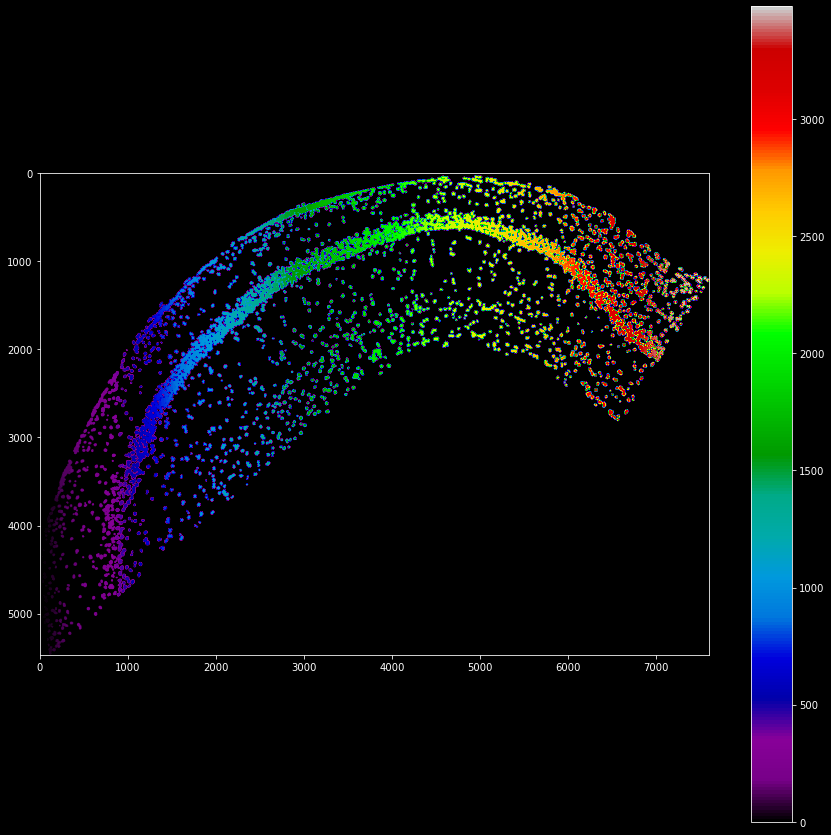

In [129]:
import io
import requests

segmentation_data_url = 'https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/segmentation/label_image.coo.npz?raw=true'

response = requests.get(segmentation_data_url)
response.raise_for_status()
segmentation_data_data = np.load(io.BytesIO(response.content),allow_pickle=True)
segmentation_data=np.zeros((segmentation_data_data.f.shape))
segmentation_data[segmentation_data_data.f.row,segmentation_data_data.f.col,]=segmentation_data_data.f.data
del segmentation_data_data

plt.imshow(segmentation_data,cmap='nipy_spectral')
plt.colorbar()

## Playground:

Here's some room to explore the pixel map functionality:

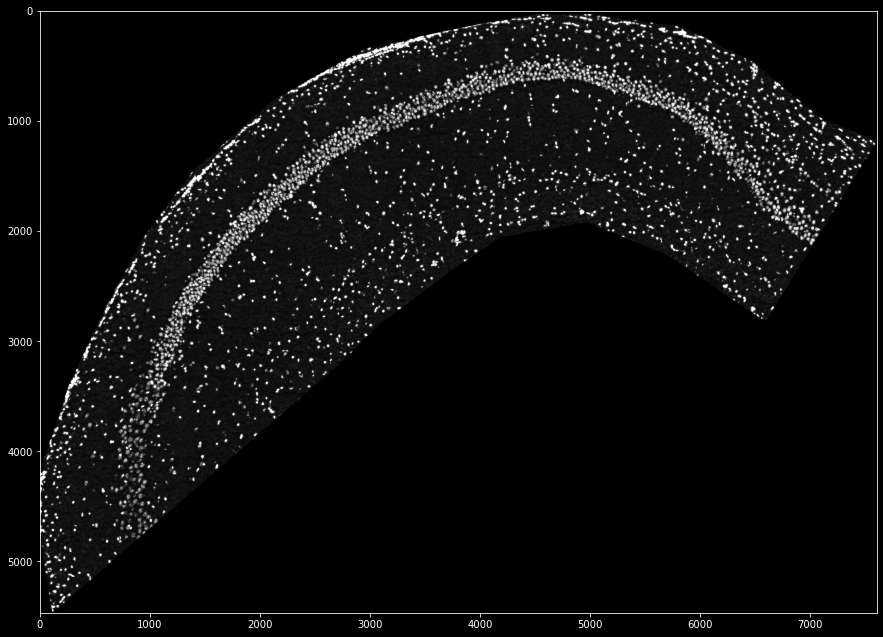

In [124]:
dapi_map = pl.PixelMap(dapi_data,upscale=0.2694)

dapi_map.imshow(cmap='Greys')

In [125]:
import plankton as pl

sdata=pl.SpatialData(spot_data.Gene,
                     spot_data.x,
                     spot_data.y,
                    pixel_maps={
                        'DAPI':dapi_map,
                        'cell_map':pl.PixelMap(cell_map)
                    })

(<matplotlib.collections.PathCollection at 0x7f5dc88475b0>, None, None)

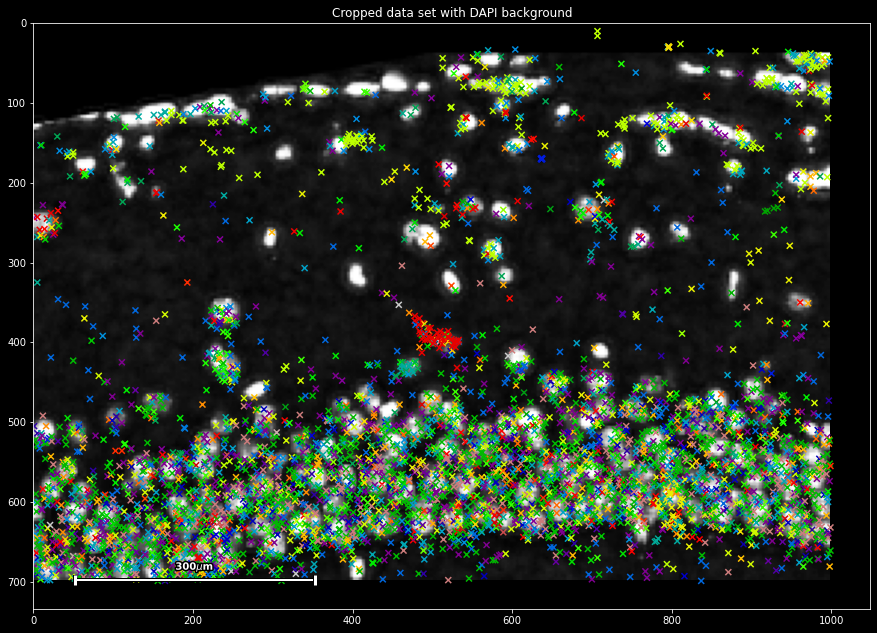

In [126]:
plt.title('Cropped data set with DAPI background')

sdata.spatial[4000:5000,0:700].scatter(marker='x',alpha=1)

In [130]:
cell_map=pl.PixelMap(segmentation_data)

In [140]:
sdata['cell']=cell_map.get_value(sdata.x,sdata.y,padding_value=0)

[5457 4735 4725 ... 1294 1287 1268]


# Single cell data:

### Loading single-cell sequencing data

In [ ]:
import anndata

sc_url = 'https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/scRNA/scRNAseq.csv.gz?raw=true'
response = requests.get(sc_url)
response.raise_for_status()
scRNAseq_data = pd.read_csv(io.BytesIO(response.content), header=None, index_col=0, compression='gzip', dtype=object,)

scRNAseq_data = scRNAseq_data.rename(columns=scRNAseq_data.iloc[0], copy=False).iloc[1:]
scRNAseq_data = anndata.AnnData(X=scRNAseq_data.astype(float)).T

scRNAseq_data.obs['celltype']=scRNAseq_data.obs.index
scRNAseq_data.obs_names_make_unique()
scRNAseq_data.var.index.name = None
scRNAseq_data.var_names_make_unique()

In [ ]:
pl.hbar_compare(sdata.stats,sdata.scanpy.stats)
plt.xticks([0,1],['spatial','scRNAseq'])

In [ ]:
knn_neighbors=200
bandwidth=60
n_neighbors=30
metric='euclidean'
min_dist=0.03
random_state=42
zero_weight=1

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



In [ ]:
sdata.graph.plot_umap()

In [ ]:
sdata.graph.umap_js()

In [ ]:
1

In [ ]:
sdata.scatter(c=sdata.graph.umap[:,0]+sdata.graph.umap[:,1]*0.3)

In [ ]:
sdata.scatter(c=sdata.graph.umap[:,1],cmap='autumn',vmin=0,vmax=10)

In [ ]:
tissues = ['radiatum','pyramidal','alveus']

tissue = np.argmax(sdata[tissues].to_numpy(),axis=1)
sdata['tissue']=(pd.Series(tissues)[tissue.astype(int)]).astype('category').values

In [ ]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)
spec = fig.add_gridspec( 1,3)

ax0 = fig.add_subplot(spec[:,:1])

sdata[sdata.alveus].graph.plot_umap(c=sdata[sdata.alveus].graph.umap[:,1],cmap='Greys')
sdata[sdata.radiatum].graph.plot_umap(c=-sdata[sdata.radiatum].graph.umap[:,1],cmap='autumn')
sdata[sdata.pyramidal].graph.plot_umap(c=np.multiply(-sdata[sdata.pyramidal].graph.umap,[1,-0.5]).sum(1),cmap='winter')

ax1 = fig.add_subplot(spec[:,1:])
sdata[sdata.alveus].scatter(c=sdata[sdata.alveus].graph.umap[:,1],cmap='Greys',scalebar=False)
sdata[sdata.radiatum].scatter(c=-sdata[sdata.radiatum].graph.umap[:,1],cmap='autumn',alpha=0.5)
sdata[sdata.pyramidal].scatter(c=np.multiply(-sdata[sdata.pyramidal].graph.umap,[1,-0.5]).sum(1),cmap='winter',scalebar=False)

In [ ]:
signatures = sdata.scanpy.generate_signatures()

In [ ]:
sdata.graph.plot_umap(c=(np.argmax(signatures.to_numpy(),axis=0)==1)[sdata.gene_ids])

In [ ]:
import utils

out = utils.ssam(sdata)

In [ ]:
np.array(out)

In [191]:
out = sdata[sdata.cell!=0].squidpy(groupby='cell')

/home/sebastian/src/planktonpy/tutorials/../plankton/plankton.py:764: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(X=X, obs=obs, var=var, obsm=obsm)


In [196]:
out.obsm

AxisArrays with keys: spatial

In [164]:
sdata.counts.values

array([4340,  943,  235, 2024,  975,  338,  799,   79,   68, 1589,  141,
          5,   33,  473,  360,   20,   58, 6712,  168,    3,  141, 1478,
       1054,   83,  560, 2534, 1083, 1102,  108,   23, 1848,  134,   95,
        124,  478, 1914,   26,  265,  277,  175,   74,  210, 9235,   73,
        181, 1186,  113,  104,  989, 1110,   74,   27, 2228, 2157,  228,
         88, 5125,   66, 2998,   43, 1324,   95,   36,   25,  180,   48,
        634,   56,  218, 1719,  188,   28,  692,  759,  117,  238,   13,
        537,  944,   53, 1480,  232,   24,  199,   52,   27,   23,  303,
        119, 2623,   25,  151])